<a href="https://colab.research.google.com/github/Vevishal/test_demo/blob/master/Segmetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 8.1 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762837 sha256=63dd4e0a49f9184435257cf5538c7f2b8b8c43013e9bd442e9b35b06fda1e681
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy


In [8]:
pip install seg-metrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 7.8 MB/s eta 0:00:00


In [9]:
# Import packages
import medpy
import medpy.metric
import numpy as np
import seg_metrics.seg_metrics as sg
import SimpleITK as sitk
import matplotlib.pyplot as plt
import copy
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import time
import gdown
import pandas as pd

In [10]:
# Load 3D CT scans: ground truth and segmentation of lobe segmentation results in the same folder.

# Download images
gdth_url_id = "1R6rph1_Wc2HfLhzvGkcNt7hgbQiHWZBY"
pred_url_id = "1cShgX96WgK_j4EbfR4wN2RLgcyVR4ca0"
gdth_fpath = "patients_26_ground_truth.nii.gz"
pred_fpath = "patients_26_segmentation.nii.gz"

gdown.download(id=gdth_url_id, output=gdth_fpath, quiet=False)
gdown.download(id=pred_url_id, output=pred_fpath, quiet=False)

# Read images and convert it to numpy array.
gdth_img = sitk.ReadImage(gdth_fpath)
gdth_np = sitk.GetArrayFromImage(gdth_img)

pred_img = sitk.ReadImage(pred_fpath)
pred_np = sitk.GetArrayFromImage(pred_img)  # note: image shape order: (z,y,x)

spacing = np.array(list(reversed(pred_img.GetSpacing())))  # note: after reverseing,  spacing order =(z,y,x)

Downloading...
From: https://drive.google.com/uc?id=1R6rph1_Wc2HfLhzvGkcNt7hgbQiHWZBY
To: /content/patients_26_ground_truth.nii.gz
100%|██████████| 1.17M/1.17M [00:00<00:00, 65.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cShgX96WgK_j4EbfR4wN2RLgcyVR4ca0
To: /content/patients_26_segmentation.nii.gz
100%|██████████| 5.05M/5.05M [00:00<00:00, 23.4MB/s]


In [11]:
# Downsampling images to save cpu and memory utility, otherwirse the Colab may raise out of memory error.
print(pred_np.shape)
gdth_np = gdth_np[::2, ::2, ::2]
pred_np = pred_np[::2, ::2, ::2]
print(pred_np.shape)

gdth_labels = np.unique(gdth_np)
print(f"ground truth labels: {gdth_labels}")


(657, 512, 512)
(329, 256, 256)
ground truth labels: [0 1 2 3 4 5]


In [12]:
def view_img(gdth, pred):
  axial_slice = int(pred_np.shape[0] * 0.45) # show all 5 lobes in this axial slice
  coronal_slice = int(pred_np.shape[1] * 0.5)
  fig = plt.figure(figsize=(10,10))
  ax_gdth = fig.add_subplot(221)
  ax_gdth.imshow(gdth[axial_slice])
  ax_gdth.set_title('ground truth (axial)')
  ax_pred = fig.add_subplot(222)
  ax_pred.imshow(pred[axial_slice])
  ax_pred.set_title('prediction (axial)')
  ax_gdth = fig.add_subplot(223)
  ax_gdth.imshow(gdth[::-1,coronal_slice,:])
  ax_gdth.set_title('ground truth (coronal)')
  ax_pred = fig.add_subplot(224)
  ax_pred.imshow(pred[::-1,coronal_slice,:])
  ax_pred.set_title('prediction (coronal)')
  plt.show()

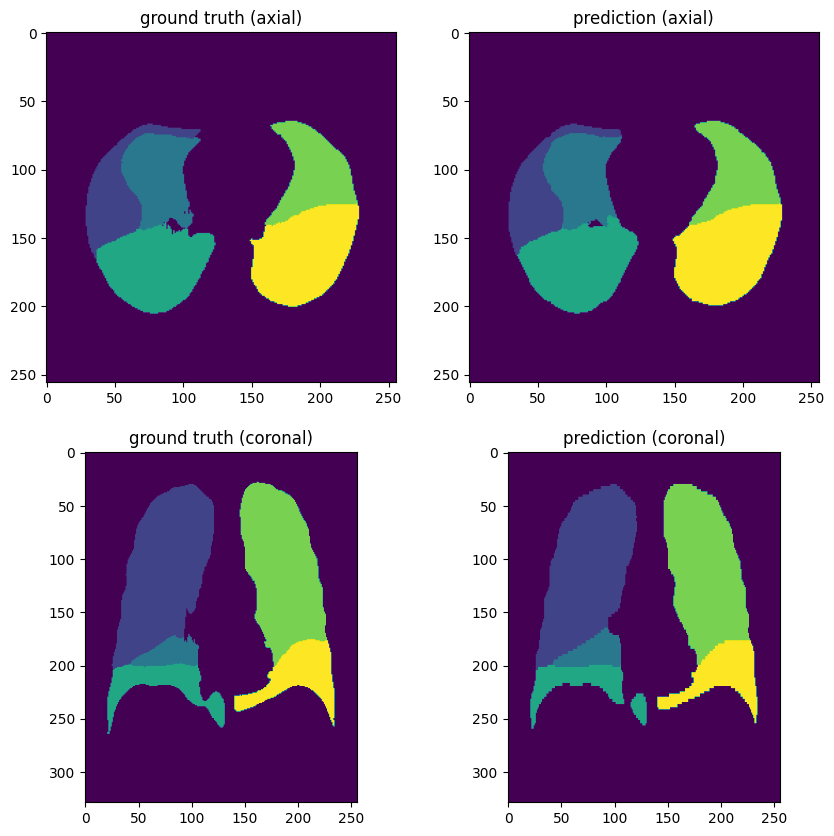

In [13]:
# Visluasize the ground truth images (5 lobes and background.
view_img(gdth_np, pred_np)

# Multi-class segmentation metrics

In [14]:
t1 = time.time()
print("Start calculating ...")  # It will cost about 40 seconds
labels = [1,2,3,4,5]
csv_file = 'metrics.csv' # or None if do not want to save metrics to csv file
metrics = sg.write_metrics(labels=labels,  # exclude background if needed
                  gdth_img=gdth_np,
                  pred_img=pred_np,
                  csv_file=csv_file,  # save results to the csv_file
                  spacing=spacing,   # assign spacing
                  metrics=['hd', 'hd95', 'msd'])
t2 = time.time()
print(f"It cost {t2-t1:.2f} seconds to finish the calculation.")
print(metrics) # a list of dict which store metrics, if given only one pair of images, list length equals to 1.
# print(metrics[0])  # a dict of metrics
df = pd.DataFrame(metrics[0])
print("=======================================")
print(df)  # Better shown by pd.DataFrame

Start calculating ...
It cost 38.02 seconds to finish the calculation.
[{'label': [1, 2, 3, 4, 5], 'hd': [3.8066790103912354, 5.875893592834473, 7.1895952224731445, 55.0378303527832, 46.238975524902344], 'msd': [0.1593415450134414, 0.2212420602479297, 0.19755631109151317, 0.16581702439248833, 0.19237908103851833], 'hd95': [0.740997314453125, 0.7410049438476562, 0.7409992218017578, 0.740997314453125, 0.740997314453125]}]
   label         hd       msd      hd95
0      1   3.806679  0.159342  0.740997
1      2   5.875894  0.221242  0.741005
2      3   7.189595  0.197556  0.740999
3      4  55.037830  0.165817  0.740997
4      5  46.238976  0.192379  0.740997


# How to obtain more metrics? like "False omission rate" or "Accuracy"?

In [15]:
t1 = time.time()
print("Start calculating the 'hd' of label [1,2] ...")  # It will cost about 40 seconds
metrics = sg.write_metrics(labels=[1,2],  # exclude background if needed
                  gdth_img=gdth_np,
                  pred_img=pred_np,
                  spacing=spacing,
                  metrics=['hd'],
                  TPTNFPFN=True)
t2 = time.time()
print(f"It cost {t2-t1:.2f} seconds to finish the calculation.")
print("=======================================")
df2 = pd.DataFrame(metrics[0])
print(df2)  # Better shown by pd.DataFrame
print("=======================================")

metric = metrics[0]
# Calculate the false_omission_rate and accuracy of label 1
tp, tn, fp, fn = metric['TP'][0], metric['TN'][0], metric['FP'][0], metric['FN'][0]
false_omission_rate = fn/(fn+tn)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(f"for label 1, false_omission_rate: {false_omission_rate}, accuracy: {accuracy}")

Start calculating the 'hd' of label [1,2] ...
It cost 718.99 seconds to finish the calculation.
   label        hd      TP          TN    FP     FN
0      1  3.806679  922092  20615053.0  7296  16903
1      2  5.875894  152797  21397207.0  6282   5058
for label 1, false_omission_rate: 0.0008192630887735511, accuracy: 0.9988776673661902
